In [1]:
# Universal Imports

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Basics of the SIR Model

The SIR model is used to depict how a particular disease may spread. This mathematical model is used to predict the spread of the disease. The model only works for diseases which you can only contract once i.e. if you build immunity towards such diseases you're not going to catch it again. This goes for diseases such as smallpox, polio, measles, and rubella. This is reasoning behind using vaccines for these diseases. 


Let's start with a few assumptions:

1. The population fits into one of these three categories

__Susceptible__ (S): those who can catch the disease  
__Infectious__ (I):  those who can spread the disease  
__Removed__ (R):     those who are immune and cannot spread the disease

2. The population is large but fixed in size and confined to a well-defined region.

3. The population is well mixed; ideally, everyone comes in contact with the same fraction of peoplein each category every day.

The disease is no longer a problem when the number Infectious goes to zero. Otherwise the flow of the disease is: 

```
+------------+              +------------+              +------------+
|            |              |            |              |            |
|Susceptible |  +-------->  | Infectious |  +-------->  | Recovered  |
|            |              |            |              |            |
+------------+              +------------+              +------------+
```

## Simple Model

So let's say for a particular disease, a person recovers after being infected for _X_ days. This means that if _I_ is the number of people infected on day _t_, then $\frac{1}{X} * I$ is the number of people who recover the next day. i.e.

<center>$R_{t+1} = R_{t} + R_{t\_new} $</center>   
<center> $R_{t\_new} = \frac{1}{X}I$</center>                     

Therefore since $\frac{1}{X}$ is a constant for a give disease; we can set:  

<center> $b = \frac{1}{X}$</center>    
<center> $R_{t\_new} = bI$</center>                                

Here b is how quickly people recover. For e.g. $b = \frac{1}{11}$ for rubella, since a person suffering from rubella takes on average 11 days for recovering from it.

We need to identify the number of people that each infective person from this population comes in contact with for the entire infection period. This could include people from _S_, _I_, _R_. Let's name this variable _c_.

    c = the average number of contacts per infective during the whole infectious period
    
How do we measure c? That's for later, for now let's assume it's a constant.

The number of contacts per infective day is given by $a = b c$ as b is (1 / number of infection days) and c is the total infection period. 

Putting together we can now derive the total number of adequate contact per day (number of people that infective people come in contact with).  

<br>
<center> $aI =$ number of adequate contact</center> 

But only people who are Susceptible can become infectious, there we can define the total number of new cases as:  

<br>
<center> new cases per day = $a\frac{S}{N}I$</center> 

Where N is the total population, $N = S + I + R$.

### Parameters for the model

    b = 1 / Average number of days infectious
    c = Average total number of contacts per infective
    a = Contacts per infective dat
    N = Total number of people 

So per day increments can now be calculated:

<center>$\Delta S = -a\frac{S}{N}I$</center>  
<center>$\Delta I =  a\frac{S}{N}I - bI$</center>  
<center>$\Delta R =  bI$</center>  

Notice that while the number of people who move from S -> I is the same, people also move from I -> R. 

### Example

Let's consider an example to solidify our thoughts. Let's consider the spread of rubella.   

We know that number of days to recover from rubella is 11 days. Therefore $b = \frac{1}{11}$. Let's consider a case where at $t_{0}$ the values are as follows:  
<br>
<center>$S = 25000$</center>
<center>$I = 1000$</center>
<center>$R = 4000$</center>

For our population let's assume c = 6.8.  

We know $a = bc$ therefore $a = \frac{1}{11}6.8 = 0.618$. 

Using this, let's plot the data for the next $t$ days.

In [218]:
def Interpolate(S: int, I: int, R: int, b: int, c: int) -> pd.DataFrame:
    import math
    
    data = [[S, I, R]]
    N = S + I + R

    a = b * c

    for i in range(1, 10000):
        S, I, R = data[i - 1][0], data[i - 1][1], data[i - 1][2]

        if I == 0:
            break

        dS = -a * (S / N) * I
        dR = b * I
        dI = -dS - dR

        SNew = math.floor(S + dS)
        INew = math.floor(I + dI)
        RNew = math.floor(R + dR)

        deltaN = N - (SNew + RNew + INew)

        # Since we're flooring, we could miss one/two people, just move them to recovered
        RNew = RNew + deltaN

        data.append([SNew, INew, RNew])

    df = pd.DataFrame(data, columns=['S', 'I', 'R'])
    
    return df

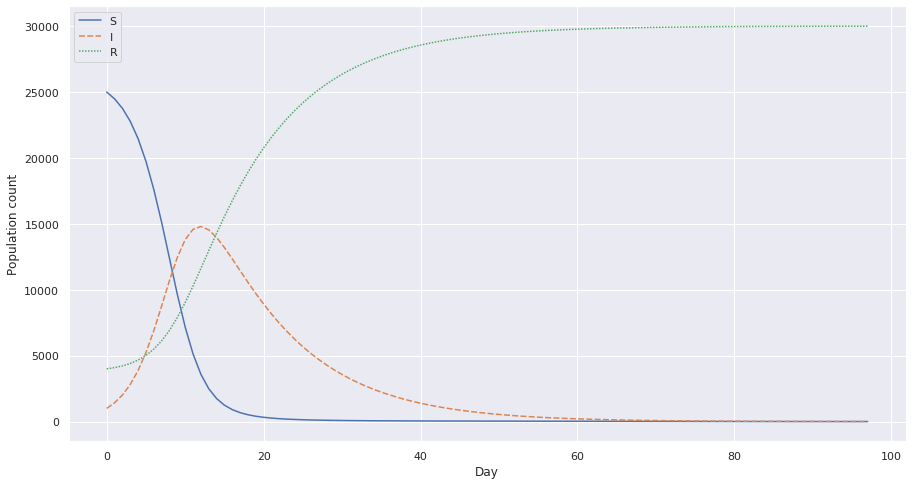

In [224]:
S, I, R = 25000, 1000, 4000

b = float(1/11)
c = 6.8

df = Interpolate(S, I, R, b, c)

plt.figure(figsize=(15,8))
ax = sns.lineplot(data=df)
ax.set(xlabel='Day', ylabel='Population count')
plt.show()

# Smaller Time Steps

Till now we were considering the values with a delta of a single day. What happens when we want to consider half day deltas or smaller?

Let's generalize the equations for $\Delta t$ days, which could be $\frac{1}{2}$ day, $\frac{1}{6}$ day, $3$ days or so forth. 

<center>$\Delta S = (-a\frac{S}{N}I) \Delta t$</center>  
<center>$\Delta R =  (bI)  \Delta t$</center>  
<center>$\Delta I =  (a\frac{S}{N}I - bI) \Delta t$</center>  

This is not too complicated. We just multiply by $\Delta t$ to get the desired values.


We can now define the change in S, I, R from time t to t + Δ𝑡 simply as follows:

$$S[t + \Delta t] = S[t] - (a\frac{S[t]}{N}I[t]) \Delta t$$
$$I[t + \Delta t] = I[t] + (a\frac{S[t]}{N}I[t] - bI[t]) \Delta t$$

Wherein we can always find $R[t]$ as follows:
$$R[t] = N - S[t] - I[t]$$

# Continous model

Now with the above equations we can derive the following

<center>$\frac{S[t + \Delta t] - S[t]}{\Delta t} =  - a\frac{S[t]}{N}I[t]$</center>  
<center>$\frac{I[t + \Delta t] - I[t]}{\Delta t} = a\frac{S[t]}{N}I[t] - bI[t]$</center> 

If you look at the right hand side, this is the equations we started off with. These equations denote the rate of change per day for S and I. 

Now to build our continous model, let's some parameters

t = time measured in days, where t=0 is the start of the epidemic
s = S/N the fraction of the population which is susceptible
i = I/N the fraction of the population which is infected
r = R/N the fraction of the population which is recovered

where N is the total population. Dividing both sides by N we get:

<center>$(\frac{S[t + \Delta t]}{N} - \frac{S[t]}{N})\frac{1}{\Delta t} =  - a\frac{S[t]}{N}\frac{I[t]}{N}$</center>  
<center>$(\frac{I[t + \Delta t]}{N} - \frac{I[t]}{N})\frac{1}{\Delta t} =  a\frac{S[t]}{N}\frac{I[t]}{N} - b\frac{I[t]}{N}$</center> 

from this we obtain

<center>$\frac{\Delta s}{\Delta t} = -asi$</center>
<center>$\frac{\Delta i}{\Delta t} = asi - bi$</center>

remember we can always get r = 1 - s - i. 

The above equations now provide us the average rate of change from $t$ to $t + \Delta t$. Considering differential calculus we can say that.

<center>$\frac{ds}{dt} = \lim_{\Delta t \to 0 } \frac{ds}{dt} = \lim_{\Delta t \to 0 } \frac{S[t + \Delta t] - S[t]}{\Delta t}$</center>
<center>$\frac{di}{dt} = \lim_{\Delta t \to 0 } \frac{di}{dt} = \lim_{\Delta t \to 0 } \frac{I[t + \Delta t] - I[t]}{\Delta t}$</center>

We since our equations for previous $\frac{\Delta s}{\Delta t}$ and $\frac{\Delta i}{\Delta t}$ don't have $\Delta t$ on the right hand side we can equate:

<center>$\frac{ds}{dt} = -asi$</center>
<center>$\frac{di}{dt} = asi - bi$</center>

In [5]:
S, I, R = 25000, 1000, 4000
b = float(1/11)
c = 1.95

In [6]:
def Interpolate(S: int, I: int, R: int, b: int, c: int) -> pd.DataFrame:
    import math
    
    data = [[S, I, R]]
    N = S + I + R

    a = b * c

    for i in range(1, 10000):
        S, I, R = data[i - 1][0], data[i - 1][1], data[i - 1][2]

        if I == 0:
            break

        dS = -a * (S / N) * I
        dR = b * I
        dI = -dS - dR

        SNew = math.floor(S + dS)
        INew = math.floor(I + dI)
        RNew = math.floor(R + dR)

        deltaN = N - (SNew + RNew + INew)

        # Since we're flooring, we could miss one/two people, just move them to recovered
        RNew = RNew + deltaN

        data.append([SNew, INew, RNew])

    df = pd.DataFrame(data, columns=['S', 'I', 'R'])
    
    return df

In [7]:
df = Interpolate(S, I, R, b, c)

,S,I,R
0,25000,1000,4000
1,24852,1056,4092
2,24696,1115,4189
3,24533,1176,4291
4,24362,1239,4399
...,...,...,...
172,7439,4,22557
173,7438,3,22559
174,7437,2,22561
175,7436,1,22563


In [207]:
fx = lambda x: math.pow(x, 4)
dydx = lambda x, y: 4 * math.pow(x, 3)
y0 = 0

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x = list(np.arange(0, 5, 0.1))
y = list(map(fx, x))

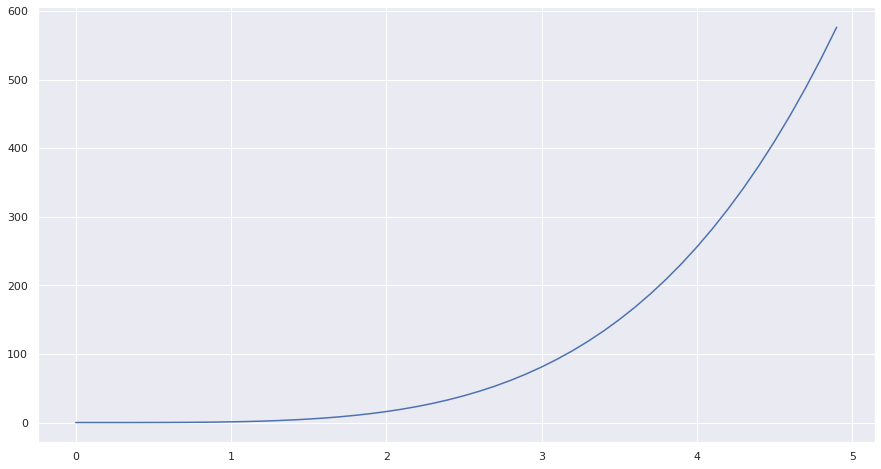

In [209]:
plt.figure(figsize=(15,8))
sns.lineplot(x=x, y=y)
plt.show()

In [210]:
def euler(fn, y0, h):
    y_old = y0
    x_old = 0
    while True:
        y_new = y_old + h * fn(x_old, y_old)
        x_old = x_old + h 
        y_old = y_new
        yield(x_old, y_old)

In [216]:
final = 5
h_values = [1, 0.5, 0.1, 0.01]
samples = {}

for h in h_values:
    gn = euler(dydx, y0, h)
    data = []
    for i in range(int(final/h)):
        data.append(next(gn))
    samples[h] = data

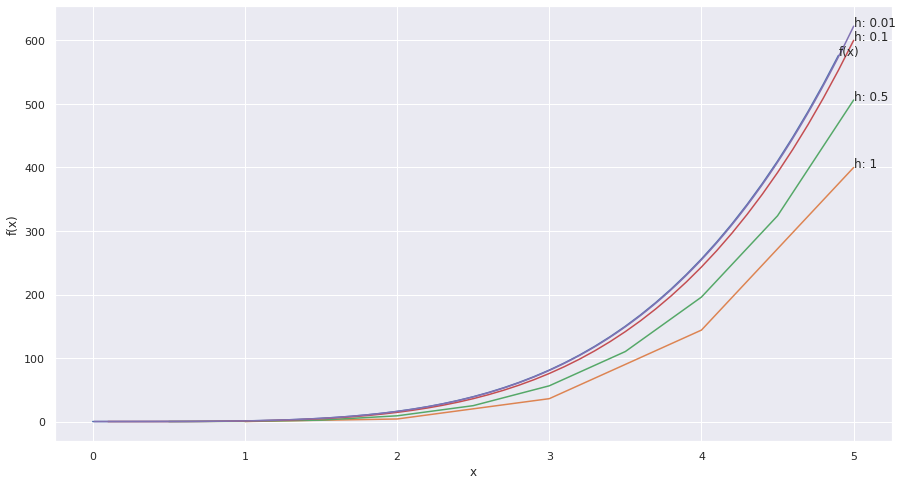

In [217]:
plt.figure(figsize=(15,8))
sns.lineplot(x=x, y=y)
plt.text(x[-1], y[-1], 'f(x)')
for h, data in samples.items():
    sns.lineplot(x=[arr[0] for arr in data], y=[arr[1] for arr in data])
    plt.text(data[-1][0], data[-1][1], 'h: {}'.format(h))
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()

In [213]:
samples[1]

[(1, 0.0), (2, 4.0), (3, 36.0), (4, 144.0), (5, 400.0)]

In [227]:
b = float(1/11)
c = 2
a = c * b

S, I, R = 25000, 1000, 4000
N = S + I + R
s0 = S/N
i0 = I/N

In [228]:
s0, i0

(0.8333333333333334, 0.03333333333333333)

# Credits

Most of the text here is mostly simplified text from: https://homepage.divms.uiowa.edu/~stroyan/CTLC3rdEd/3rdCTLCText/Chapters/Ch2.pdf
